In [1]:
!pip install mlflow pyvi minio -q
import mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 60.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 99.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 97.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00


In [2]:
mlflow.set_tracking_uri("http://36.50.135.226:7893/")

# from mlflow.tracking import MlflowClient

# client = MlflowClient()
# client.restore_experiment(experiment_id="2")

mlflow.set_experiment(experiment_id="12")

<Experiment: artifact_location='s3://mlflow/8', creation_time=1746431673147, experiment_id='12', last_update_time=1746431673147, lifecycle_stage='active', name='Eval_15Epoch_TrainFullData_TPC3k7_BartPho-ViT-GPT2_LoRALayerFT_AllMetrics', tags={}>

In [3]:
import os

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://36.50.135.226:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import json
import transformers
from transformers import VisionEncoderDecoderModel, ViTImageProcessor
import torch
from PIL import Image
import torch.nn as nn
import cv2
import torchvision
from tqdm.notebook import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTImageProcessor
from collections import OrderedDict
from transformers import GPT2Config, GPT2LMHeadModel
import mlflow
import mlflow.pytorch
import re
from pyvi import ViTokenizer
from torch.optim import AdamW

2025-05-12 04:28:12.467579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747024092.647759      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747024092.702585      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Adjust component

In [5]:
"""
2. Load feature extractor
"""
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

def load_image(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        if response.status_code != 200:
            print(f"Error: Failed to fetch image, status code {response.status_code}")
            return None

        image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        if image is None:
            print("Error: OpenCV could not decode the image.")
            return None

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb
    except requests.exceptions.RequestException as e:
        print(f"Error: Request failed - {e}")
        return None


def load_image_evaluate(local_path, dataset_base_path="/kaggle/input/traffic-pictures-captioning/"):
    """
    Load ảnh từ local_path trong dataset trên Kaggle.
    
    Parameters:
    - local_path (str): Đường dẫn tương đối của ảnh (từ cột 'url' trong DataFrame)
    - dataset_base_path (str): Đường dẫn gốc đến dataset
    
    Returns:
    - image_rgb (numpy.ndarray): Ảnh ở định dạng RGB, hoặc None nếu lỗi
    """
    try:
        # Chuẩn hóa đường dẫn ảnh
        local_path = local_path.lstrip('./')  # Loại bỏ './' nếu có
        full_image_path = os.path.join(dataset_base_path, local_path)
        
        # Đọc ảnh bằng OpenCV
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Lỗi: Không thể đọc ảnh từ {full_image_path}")
            return None
        
        # Chuyển từ BGR sang RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb
    
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {full_image_path}: {e}")
        return None

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [6]:
"""
3. Load Tokenizer
"""
from transformers import AutoTokenizer

# Load tokenizer của BartPho
# tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-word")

# Kiểm tra vocab size
vocab_size = tokenizer.vocab_size
print(f"VOCAB SIZE: {vocab_size}")

# In ra các special tokens
print("Special Tokens:", tokenizer.special_tokens_map)

config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

VOCAB SIZE: 64000
Special Tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}


# 1. Generate Model

In [7]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/input/phovit-gptcap/pytorch/default/15'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)

# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path, evaluate=False):
    if evaluate == False:
        img = load_image(image_path)
    else:
        img = load_image_evaluate(image_path)

    if img is None:
        return None
    pixel_values =  feature_extractor(img, return_tensors="pt")["pixel_values"]
    output_ids = model.generate(
        pixel_values,
        max_length=60,
        min_length=20,
        num_beams=4,  # Tối ưu tốc độ
        do_sample=True,
        temperature=0.8,  # Giảm nhiệt độ
        top_k=20,
        top_p=0.9,  # Mở rộng lựa chọn từ
        no_repeat_ngram_size=3,  # Ngăn lặp cụm 5 từ
        repetition_penalty=2.0,  # Phạt lặp mạnh hơn
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=tokenizer.bos_token_id
    )
    print(output_ids[0])
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # caption = caption.replace("_", " ").strip()  # Loại bỏ dấu gạch dưới
    print(caption)
    return caption

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from io import BytesIO
from PIL import Image
import numpy as np

def sub_fig_to_image(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    return np.array(img)
    
def display_images_in_4_frames_only_big_borders(model, image_urls):
    assert len(image_urls) == 12, "Cần đúng 12 ảnh để chia đều thành 4 frame (3 ảnh mỗi frame)"

    num_frames = 4
    images_per_frame = 3

    fig, frame_axes = plt.subplots(2, 2, figsize=(14, 12))  # Tăng khung chính

    for idx in range(num_frames):
        start = idx * images_per_frame
        end = start + images_per_frame
        sub_image_urls = image_urls[start:end]

        # 👉 Tăng chiều cao của sub_fig cho caption hiển thị thoải mái
        sub_fig, axes = plt.subplots(images_per_frame, 2, figsize=(8, 6))  # chiều cao tăng

        for i, image_url in enumerate(sub_image_urls):
            try:
                image_rgb = load_image(image_url)
                caption = predict_internet_caption(model, image_url)

                axes[i][0].imshow(image_rgb)
                axes[i][0].axis('off')

                # 👉 Cập nhật cách hiển thị caption: căn trái + wrap + padding
                axes[i][1].text(0, 1, caption,
                                fontsize=14,
                                ha='left',
                                va='top',
                                wrap=True,
                                transform=axes[i][1].transAxes)
                axes[i][1].axis('off')

            except Exception as e:
                print(f"Lỗi ở frame {idx}, ảnh {i}: {e}")
                axes[i][0].axis('off')
                axes[i][1].axis('off')

        sub_fig.tight_layout()
        img = sub_fig_to_image(sub_fig)
        axes_fig = frame_axes[idx // 2][idx % 2]
        axes_fig.imshow(img)
        axes_fig.axis('off')

        # Viền đậm
        rect = Rectangle((0, 0), 1, 1, transform=axes_fig.transAxes,
                         linewidth=3, edgecolor='black', facecolor='none')
        axes_fig.add_patch(rect)

        plt.close(sub_fig)

    fig.tight_layout()
    fig.savefig("four_frames_with_only_big_borders_fixed.png", dpi=300, bbox_inches='tight')
    plt.show()


In [9]:
# Danh sách URL ảnh
image_urls = [
    "https://cafebiz.cafebizcdn.vn/162123310254002176/2024/1/1/9-anh-1-via-he-duong-hung-vuong-quan-5-duoc-son-ke-vach-vang-ai-my-17040246564941929810802-1704073600647-17040736007441442461735.jpg",
    "https://cdn.tiasang.com.vn/tiasang-media/2023/05/tam-hon-via-he-anh-3-1.jpg",
    "https://images2.thanhnien.vn/528068263637045248/2023/4/4/z4237593743712668a5b49fea4d26c0efe4ddc786c07eb-1680612929609807731264.jpg",
    "https://media-cdn-v2.laodong.vn/Storage/NewsPortal/2020/6/7/810845/Nha-Cho-Xe-Buyt-2.jpg",
    "https://baogiaothong.mediacdn.vn/upload/images/2019-2/article_img/2019-06-04/xe-buyt-1559642958-width1119height902.png",
    "https://afamilycdn.com/2017/img-0296-1496895273614.jpg",
    "https://cdn.thuvienphapluat.vn/uploads/tintuc/2023/11/09/nguoi-di-bo-qua-duong.jpg",
    "https://bna.1cdn.vn/2025/01/05/bna_9.anh-pv.jpg",
    "https://nld.mediacdn.vn/2018/img2516-1514790225160.jpg",
    "https://images2.thanhnien.vn/528068263637045248/2023/6/12/mua-o-ha-noi-1686551439356797545688.jpg",
    "https://shop2banh.vn/images/2022/07/20220713_7a5c7c723d44cdc6af056a742fdd06b3_1657683871.jpeg",
    "https://baodongnai.com.vn/file/e7837c02876411cd0187645a2551379f/dataimages/202305/original/images2527906_5a.jpg",
]
# Hiển thị ảnh với bố cục dọc
# display_images_in_4_frames_only_big_borders(model, image_urls)

In [10]:
# Danh sách URL ảnh
image_urls = [
    "https://cafebiz.cafebizcdn.vn/162123310254002176/2024/1/1/9-anh-1-via-he-duong-hung-vuong-quan-5-duoc-son-ke-vach-vang-ai-my-17040246564941929810802-1704073600647-17040736007441442461735.jpg",
    "https://cdn.tiasang.com.vn/tiasang-media/2023/05/tam-hon-via-he-anh-3-1.jpg",
    "https://image.plo.vn/w1000/Uploaded/2025/liwbzivo/2022_10_14/900s-8167.jpeg.webp",
    "https://media-cdn-v2.laodong.vn/Storage/NewsPortal/2020/6/7/810845/Nha-Cho-Xe-Buyt-2.jpg",
    "https://baogiaothong.mediacdn.vn/upload/images/2019-2/article_img/2019-06-04/xe-buyt-1559642958-width1119height902.png",
    "https://afamilycdn.com/2017/img-0296-1496895273614.jpg",
    "https://cdn.thuvienphapluat.vn/uploads/tintuc/2023/11/09/nguoi-di-bo-qua-duong.jpg",
    "https://bna.1cdn.vn/2025/01/05/bna_9.anh-pv.jpg",
    "https://nld.mediacdn.vn/2018/img2516-1514790225160.jpg",
    "https://images2.thanhnien.vn/528068263637045248/2023/6/12/mua-o-ha-noi-1686551439356797545688.jpg",
    "https://shop2banh.vn/images/2022/07/20220713_7a5c7c723d44cdc6af056a742fdd06b3_1657683871.jpeg",
    "https://baodongnai.com.vn/file/e7837c02876411cd0187645a2551379f/dataimages/202305/original/images2527906_5a.jpg",
]
# Hiển thị ảnh với bố cục dọc
# display_images_in_4_frames_only_big_borders(model, image_urls)

In [11]:
# # Danh sách URL ảnh
# image_urls = [
#     "https://file3.qdnd.vn/data/images/0/2025/04/04/upload_2201/tr4%203.jpg?dpi=150&quality=100&w=870",
#     "https://csgt-congan.hochiminhcity.gov.vn/wps/wcm/connect/3a334387-024e-4516-b496-3743b31916e1/1/470f34ab382de073b93c.jpg?MOD=AJPERES&CACHEID=3a334387-024e-4516-b496-3743b31916e1/1",
#     "https://kbn.vn/wp-content/uploads/2018/08/Lap-dat-go-giam-toc-cao-su-kbS350-tai-lang-dai-hoc.jpg",
#     "https://image.tienphong.vn/w1966/Uploaded/2025/krpexlpve-byrylex/2023_04_07/tp-7-2-2442.jpg",
#     "https://baogiaothong.mediacdn.vn/upload/images/2022-4/article_img/2022-10-24/img-bgt-2021-dca4f60650ab97f5ceba-1666627257-width1280height920.jpg",
#     "https://baokhanhhoa.vn/file/e7837c02857c8ca30185a8c39b582c03/dataimages/202005/original/images5404417_nap_cong_be_nguy_hiem.jpg",
#     "https://cdn-images.vtv.vn/zoom/640_400/562122370168008704/2023/10/20/photo1697772338858-16977723393571200969407.jpg",
#     "https://vcdn1-vnexpress.vnecdn.net/2023/06/20/Vung-Tau-ngap-5766-1658301310-7085-1687249572.jpg?w=460&h=0&q=100&dpr=2&fit=crop&s=TUw6eHlKu5p1-M-tpsf4pg",
#     "https://cdn2.tuoitre.vn/thumb_w/480/471584752817336320/2024/10/8/base64-17283718455262095920496.jpeg",
#     "https://shop2banh.vn/images/2022/07/20220713_7a5c7c723d44cdc6af056a742fdd06b3_1657683871.jpeg",
#     "https://cdn.thuvienphapluat.vn/uploads/tintuc/2024/11/28/thong-ke-tai-nan-gt.jpg",
#     "https://bcp.cdnchinhphu.vn/334894974524682240/2022/12/27/sau-tai-nan-khien-8-nguoi-chet-ra-soat-lai-bat-cap-tren-ql5-1672107677884260796888.jpg",
#     # "https://media-cdn-v2.laodong.vn/Storage/NewsPortal/2021/3/26/893015/Ham-Di-Bo-7.jpg",
#     # "https://image.plo.vn/w1000/Uploaded/2025/znorgt/2024_03_14/tp-thu-duc-5026.jpg.webp",
#     # "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRzuybBrH_3SyTdH9d-e5vZ0Q1nRJlKgfl6AA&s",
# ]

# # Hiển thị ảnh với bố cục dọc
# display_images_in_4_frames_only_big_borders(model, image_urls)

# Show Predict - Actual

In [12]:
def load_image_kaggle(local_path, dataset_base_path="/kaggle/input/traffic-pictures-captioning/"):
    """
    Load ảnh từ local_path trong dataset trên Kaggle.
    
    Parameters:
    - local_path (str): Đường dẫn tương đối của ảnh (từ cột 'url' trong DataFrame)
    - dataset_base_path (str): Đường dẫn gốc đến dataset
    
    Returns:
    - image_rgb (numpy.ndarray): Ảnh ở định dạng RGB, hoặc None nếu lỗi
    """
    try:
        # Chuẩn hóa đường dẫn ảnh
        local_path = local_path.lstrip('./')  # Loại bỏ './' nếu có
        full_image_path = os.path.join(dataset_base_path, local_path)
        
        # Đọc ảnh bằng OpenCV
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Lỗi: Không thể đọc ảnh từ {full_image_path}")
            return None
        
        # Chuyển từ BGR sang RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb
    
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {full_image_path}: {e}")
        return None

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
import requests
from io import BytesIO
import numpy as np

def show_4_images_with_captions(image_paths, actual_dict, predicted_dict):
    assert len(image_paths) == 4, "Cần đúng 4 ảnh"

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12), width_ratios=[0.40, 0.60])
    
    for i, image_path in enumerate(image_paths):
        # Ảnh
        try:
            local_path = image_path.lstrip('./')  # Loại bỏ './' nếu có
            full_image_path = os.path.join("/kaggle/input/traffic-pictures-captioning/", local_path)
            # Đọc ảnh bằng OpenCV
            image = cv2.imread(full_image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Lỗi khi load ảnh {i}: {e}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        axes[i, 0].imshow(image_rgb)
        axes[i, 0].axis("off")

        # Caption
        actual = actual_dict.get(i, ["Không có"])[0]
        predict = predicted_dict.get(i, ["Không có"])[0]
        text = f"ACTUAL: {actual}\n\nPREDICT: {predict}"

        axes[i, 1].text(0, 1, text, fontsize=16.5, va="top", ha="left", wrap=True, transform=axes[i, 1].transAxes)
        axes[i, 1].axis("off")

    fig.tight_layout()
    fig.savefig("four_image_predict.png", dpi=300, bbox_inches='tight')
    plt.show()


In [14]:
def predict_and_show(test_df):
    actual, predicted, image_urls = {}, {}, {}
    progress_bar = tqdm(test_df.iterrows(), total=len(test_df))

    for index, row in progress_bar:
        captions = [row['caption']]
        image_url = row['url']
        y_pred = predict_internet_caption(model, image_url, evaluate=True)

        if pd.isna(y_pred) or image_url.strip() == "":
            continue
        image_urls[index] = image_url
        actual[index] = captions
        predicted[index] = [y_pred]
    show_4_images_with_captions(list(image_urls.values()), actual, predicted)

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([    0,   448, 17922,     4,  1690,  2633,   216,    71,     6,  8994,
           18,    57,   215,   145,    41,     5,  5236,   963,   109,   365,
           13,    18,    57,  4899,   216,    71,     5,    16,   981,    52,
         1263,    39,    41,   295,   732,     5,   402,    13,    49,  1263,
            5,     2])
giao thông thưa thớt , đèn tín hiệu phía trước và biển báo người đi bộ bên phải . vạch kẻ đường dành cho người đi bi phía trước . một xe máy đang di chuyển từ phải sang trái . an toàn cho việc di chuyển .
tensor([    0,   448, 17922,     4,   825,   981,     5,  5236,   963,   109,
          365,    13,    18,    57,   215,   339,   216,    71,     5,   981,
         1263,   145,    41,     5,  1263,   402,   145,   732,     5,     2])
giao thông thưa thớt , chủ yếu xe máy . vạch kẻ đường dành cho người đi bộ nằm phía trước . xe máy di chuyển bên phải . di chuyển an toàn bên trái .
tensor([    0,   448,   281, 17922,     4,    18,    57,   215,  1731,    89

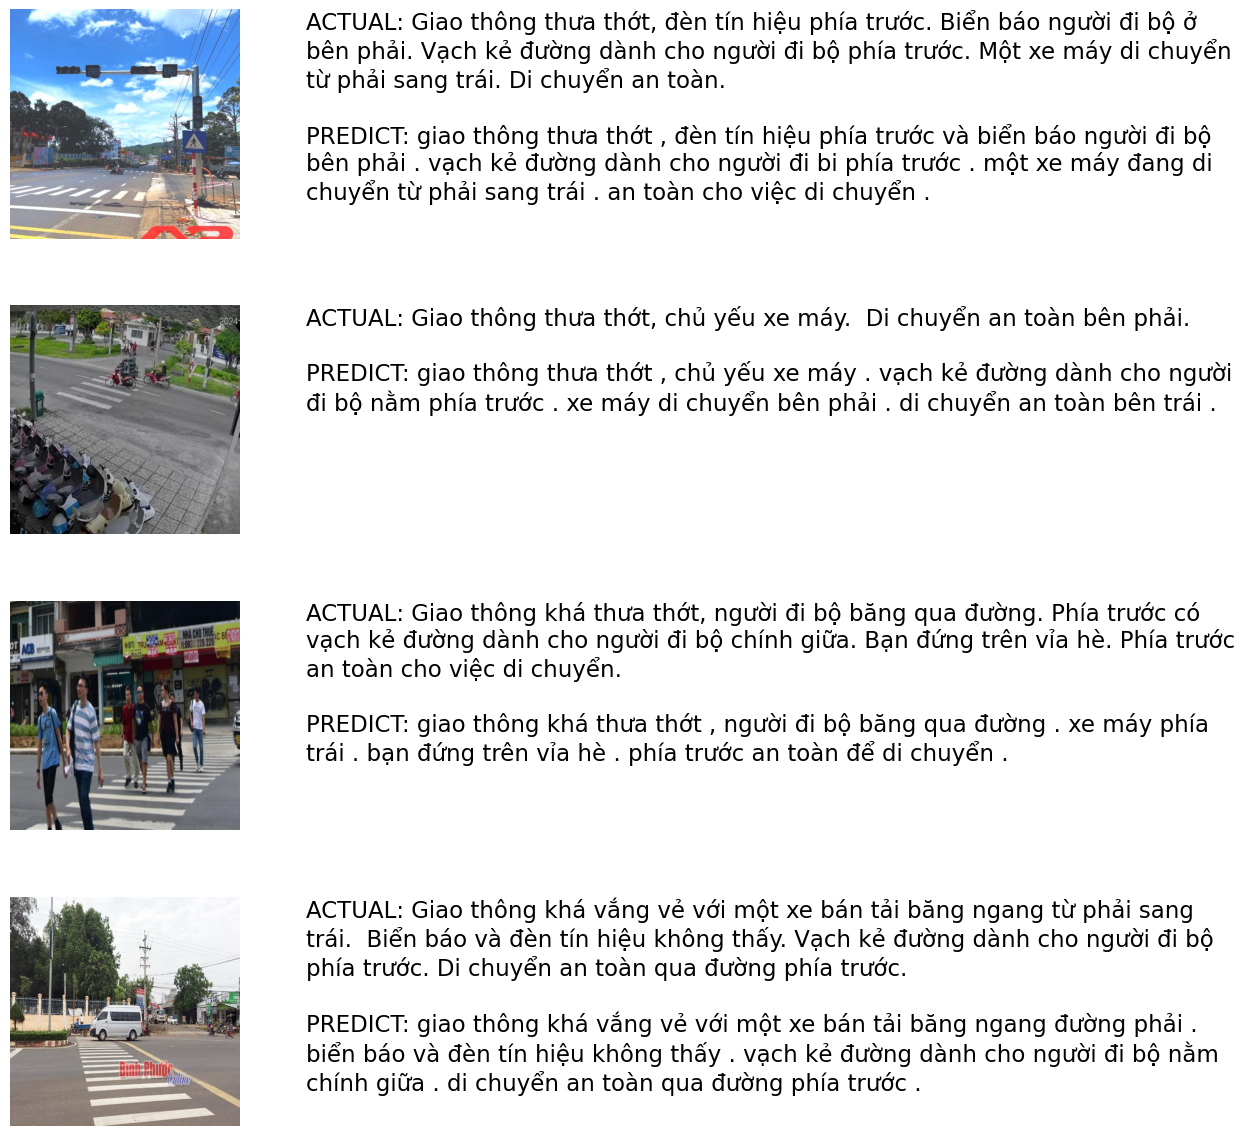

In [37]:
test = pd.read_json("/kaggle/input/traffic-augment/test.json")

# predict_and_show(test.tail(4).reset_index(drop=True))
# predict_and_show(test.sample(4).reset_index(drop=True))

# Danh sách các chỉ số bạn muốn chọn, ví dụ:
# custom_indexes = [3, 27, 45, 67] # Vỉa hè
# custom_indexes = [128, 378, 345, 340] # Hầm đi bộ
custom_indexes = [180, 371, 83, 170] # Vạch kẻ đường 371, 83

# Lấy các dòng tương ứng từ DataFrame test
selected_rows = test.loc[custom_indexes].reset_index(drop=True)

# Gọi hàm predict_and_show
predict_and_show(selected_rows)